# Download Dataset

In [ ]:
!wget https://www.mdpi.com/article/10.3390/s24186157/s1

--2024-12-02 04:01:11--  https://www.mdpi.com/article/10.3390/s24186157/s1
Resolving www.mdpi.com (www.mdpi.com)... 104.18.24.151, 104.18.25.151
Connecting to www.mdpi.com (www.mdpi.com)|104.18.24.151|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /1424-8220/24/18/6157/s1 [following]
--2024-12-02 04:01:11--  https://www.mdpi.com/1424-8220/24/18/6157/s1
Reusing existing connection to www.mdpi.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://mdpi-res.com/d_attachment/sensors/sensors-24-06157/article_deploy/sensors-24-06157-s001.zip?version=1727173302 [following]
--2024-12-02 04:01:11--  https://mdpi-res.com/d_attachment/sensors/sensors-24-06157/article_deploy/sensors-24-06157-s001.zip?version=1727173302
Resolving mdpi-res.com (mdpi-res.com)... 104.26.15.90, 172.67.68.164, 104.26.14.90, ...
Connecting to mdpi-res.com (mdpi-res.com)|104.26.15.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

In [ ]:
!unzip -l s1

Archive:  s1
  Length      Date    Time    Name
---------  ---------- -----   ----
  1119781  2024-08-07 17:28   game_gestures.db.csv
     1887  2024-08-07 17:28   __MACOSX/._game_gestures.db.csv
     4904  2024-08-12 18:46   README 1.md
     1110  2024-08-12 18:46   __MACOSX/._README 1.md
    61924  2024-08-12 18:46   README 1.pdf
     1113  2024-08-12 18:46   __MACOSX/._README 1.pdf
---------                     -------
  1190719                     6 files


In [ ]:
!unzip s1 -x "__MACOSX/*" "README*"

Archive:  s1
  inflating: game_gestures.db.csv    


In [ ]:
!head game_gestures.db.csv

ID_person;age;gender;gesture;repetition;recording;time;index.bend;thumb.bend;little.bend;middle.bend;ring.bend;index.pressure;thumb.pressure;little.pressure;middle.pressure;ring.pressure;imu.orientEulX;imu.orientEulY;imu.orientEulZ;imu.orientQuatX;imu.orientQuatY;imu.orientQuatZ;imu.orientQuatW;imu.linacceleX;imu.linacceleY;imu.linacceleZ
8;59;M;wave right;1;2;"[0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200
 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380
 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560
 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740
 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920
 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080
 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200]";"[5100 5100 5105 5108 5096 5113 5105 5097 5109 5117 5164 5160 5152 5153
 5153 5156 5177 5152 5152 5168 5153 5164 5153 5165 5116 5152 

# Import required libraries


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


## Data preprocessing functions

In [ ]:
def preprocess_data(df):
    """Preprocess the sensor data from CSV file."""
    # Convert sensor data from string arrays to numpy arrays
    sensor_columns = [col for col in df.columns if any(x in col for x in ['bend', 'pressure', 'imu', 'time'])]

    for col in sensor_columns:
        # Convert string of space-separated values to numpy arrays
        df[col] = df[col].str.strip('[]').str.split(expand=False).apply(lambda x: [float(i) for i in x])

    # Encode categorical variables
    le = LabelEncoder()
    df['gender'] = le.fit_transform(df['gender'])
    df['gesture'] = le.fit_transform(df['gesture'])

    return df


## Feature Extraction

In [ ]:
def extract_features(row):
    """Extract features from sensor data for each recording."""
    features = []

    # Add static features
    features.extend([row['age'], row['gender']])

    # Define sensor groups for feature extraction
    sensor_groups = {
        'bend': [col for col in row.index if 'bend' in col],
        'pressure': [col for col in row.index if 'pressure' in col],
        'orientation': [col for col in row.index if 'orient' in col],
        'acceleration': [col for col in row.index if 'linaccele' in col]
    }

    # Extract features for each sensor group
    for _, columns in sensor_groups.items():
        for col in columns:
            values = row[col]
            features.extend([
                np.mean(values),
                np.std(values),
                np.max(values),
                np.min(values),
                np.median(values),
                np.percentile(values, 25),
                np.percentile(values, 75)
            ])

    return np.array(features)


## Model creation function

In [ ]:
def create_model(input_shape):
    """Create the neural network model according to the paper's architecture."""
    inputs = tf.keras.Input(shape=(input_shape,))

    # Reshape input for 2D convolution
    # Calculate appropriate dimensions
    # 142 features = bend(5) + pressure(5) + imu(10) sensors with multiple readings
    x = tf.keras.layers.Reshape((71, 2, 1))(inputs)  # Reshape to 71x2 grid

    # First Conv2D layer
    x = tf.keras.layers.Conv2D(32, (3, 3),
                              activation='relu',
                              padding='same',
                              name='conv1')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Second Conv2D layer
    x = tf.keras.layers.Conv2D(64, (3, 3),
                              activation='relu',
                              padding='same',
                              name='conv2')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Third Conv2D layer
    x = tf.keras.layers.Conv2D(64, (3, 3),
                              activation='relu',
                              padding='same',
                              name='conv3')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Flatten
    x = tf.keras.layers.Flatten()(x)

    # Dense layers
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)  # 5 gestures

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


## Training Implementation

In [ ]:
def train_and_evaluate(data_path, epochs=50):
    """Train and evaluate the model with the paper's parameters."""
    # Load and preprocess data
    data = pd.read_csv(data_path, sep=';')
    processed_data = preprocess_data(data)

    # Prepare features and labels
    X = np.array([extract_features(row) for _, row in processed_data.iterrows()])
    y = processed_data['gesture'].values

    print("Input shape:", X.shape)  # Print shape for debugging

    # Split the data with the same ratio as the paper
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and train model
    model = create_model(X_train.shape[1])

    print("\nModel Architecture:")
    model.summary()


    # Use the same callbacks as the paper
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=5,
            min_lr=0.00001
        )
    ]

    # Train with batch size from paper
    history = model.fit(
        X_train_scaled, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
    print(f"\nTest accuracy: {test_accuracy:.4f}")

    # Print metrics similar to paper
    y_pred = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)

    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))

    return model, history, scaler


## Results Visualization

In [ ]:
def plot_training_history(history):
    """Plot training history following the paper's visualization style."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], 'b-', label='Training')
    ax1.plot(history.history['val_accuracy'], 'r-', label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True)
    ax1.legend()

    # Loss plot
    ax2.plot(history.history['loss'], 'b-', label='Training')
    ax2.plot(history.history['val_loss'], 'r-', label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

## Saving and Results

In [ ]:
def save_results(model, scaler, history, save_path):
    """Save the model and related components."""
    # Create directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Save model in newer .keras format
    model.save(f'{save_path}/glove_model.keras')

    joblib.dump(scaler, f'{save_path}/scaler.pkl')

    # Save training history
    with open(f'{save_path}/training_history.json', 'w') as f:
        history_dict = {
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy'],
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss']
        }
        json.dump(history_dict, f)


## Let's do training

In [ ]:
data_path = 'game_gestures.db.csv'
model, history, scaler = train_and_evaluate(data_path, epochs=50)

Input shape: (100, 142)

Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 142)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 71, 2, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 71, 2, 32)           │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 71, 2, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 71, 2, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 71, 2, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 71, 2, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 71, 2, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,163,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,228,357 (4.69 MB)

 Trainable params: 1,228,037 (4.68 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.2500 - loss: 2.4281 - val_accuracy: 0.2500 - val_loss: 1.5903 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6562 - loss: 1.2527 - val_accuracy: 0.3125 - val_loss: 1.5769 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8021 - loss: 0.6859 - val_accuracy: 0.6250 - val_loss: 1.5537 - learning_rate: 0.0010
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8125 - loss: 0.6427 - val_accuracy: 0.8125 - val_loss: 1.5262 - learning_rate: 0.0010
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8125 - loss: 0.4667 - val_accuracy: 0.6875 - val_loss: 1.4991 - learning_rate: 0.0010
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8646 - loss: 0.3727 - val_accuracy: 0.7500 - val_loss: 1.4733 - learning_rate: 0.0010
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8750 - loss: 0.5334 - val_accuracy: 

## Store Results

In [ ]:
save_path = 'results'
save_results(model, scaler, history, save_path)

## Visualistion

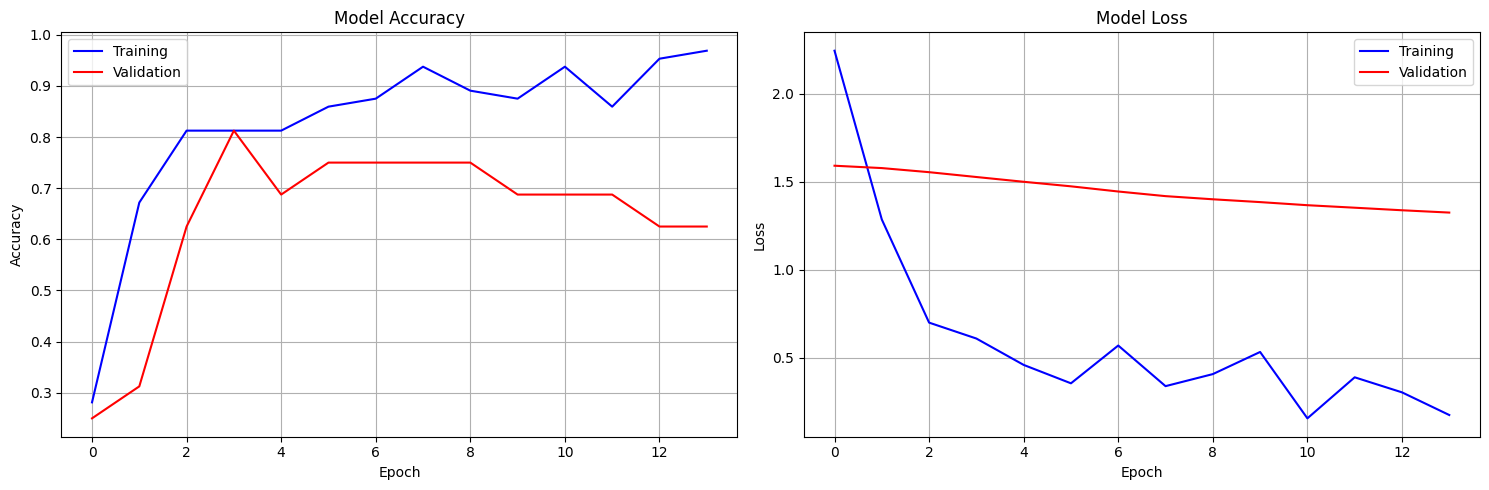

In [ ]:
plot_training_history(history)